# Assignment 3
# 2D Fault Detection
### Due date: December 13, 2021
In this code, a neural network model will be trained with synthetic data as an image segmentation solution to detect faults on seismic sessions.\
Your work: 

* complete missing parts (in loading data)
* write the network.
* try predicting on the validation set

First, loading some packages:

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')
import glob
import time
from zipfile import ZipFile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_name="/content/drive/MyDrive/fault2d.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall("/content/Dataset")
  print('Done')


Done


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data reading and preprocessing
The data for this assignment is in D2L. It consist of a zip file with seismic images and labels (masks).\
The data are already divided in training and validation.


Setting image files locations:

In [ ]:
# Write the path to the files (read from D2L and upload to COLAB or copy to your system) 
# MYPATH= "/content/Dataset"

In [ ]:
# # Training set
# folder_train_x = MYPATH + "2D_train/seis/*.png"
# folder_train_y = MYPATH + "2D_train/fault/*.png"

# # Validation set
# folder_validation_x =   MYPATH+"2D_validation/seis/*.png"
# folder_validation_y = MYPATH+"2D_validation/fault/*.png"

In [5]:
# Training set
folder_train_x = "/content/Dataset/2D_train/seis/*png"
folder_train_y = "/content/Dataset/2D_train/fault/*png"

# Validation set
folder_validation_x =  "/content/Dataset/2D_validation/seis/*png"
folder_validation_y = "/content/Dataset/2D_validation/fault/*png"

Defining meta-data:

In [6]:
image_size = (128, 128)
batch_size = 20
seed = 666

Loading images and masks:
Using as example the code for the 
* folder_train_x, \
complete the reading, loading and preprocessing for:
* folder_train_y, 
* folder_validation_x 
* folder_validation_y.

In [7]:
# Training
xfiles = glob.glob(folder_train_x)
yfiles = glob.glob(folder_train_y)
xfiles = np.sort(xfiles)
yfiles = np.sort(yfiles)
train_images = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in xfiles])
train_masks = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in yfiles])

In [8]:
print(train_images.shape, train_masks.shape)

(2600, 128, 128) (2600, 128, 128)


In [9]:
# Validation
xfiles = glob.glob(folder_validation_x)
yfiles =  glob.glob(folder_validation_y)
xfiles = np.sort(xfiles)
yfiles = np.sort(yfiles)
validation_images = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in xfiles])
validation_masks = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in yfiles])

In [10]:
print(validation_images.shape, validation_masks.shape)


(260, 128, 128) (260, 128, 128)


Reshaping `numpy` arrays for the modeling:

In [11]:
# Training set
train_images = train_images.reshape(-1,128,128,1)
train_masks = train_masks.reshape(-1,128,128,1)

# Validation set
validation_images = validation_images.reshape(-1,128,128,1)
validation_masks = validation_masks.reshape(-1,128,128,1)

Data augmentation:

In [12]:
train_images = np.append(train_images, [np.fliplr(x) for x in train_images], axis=0)
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0)
train_images = np.append(train_images, [np.flipud(x) for x in train_images], axis=0)
train_masks = np.append(train_masks, [np.flipud(x) for x in train_masks], axis=0)

Text(0.5, 0.98, 'Top row: original images, bottom 3 rows: augmented images')

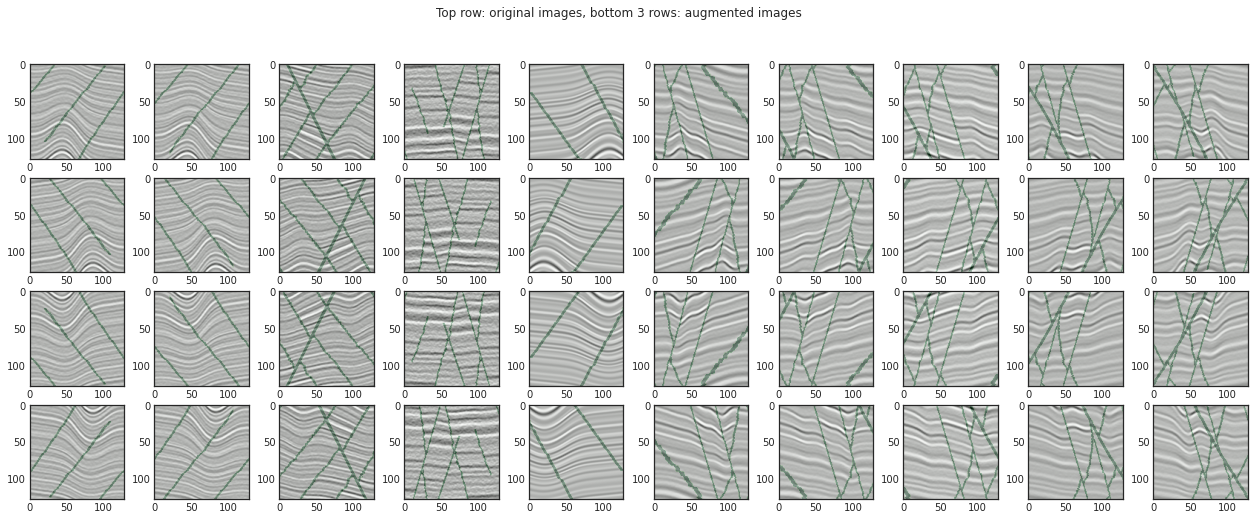

In [13]:
fig, axs = plt.subplots(4, 10, figsize=(22,8))
for i in range(10):
    axs[0][i].imshow(train_images[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(train_masks[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(train_images[int(len(train_images)/4 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(train_masks[int(len(train_masks)/4 + i)].squeeze(), cmap="Greens", alpha=0.3)
    axs[2][i].imshow(train_images[int(len(train_images)/2 + i)].squeeze(), cmap="Greys")
    axs[2][i].imshow(train_masks[int(len(train_masks)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
    axs[3][i].imshow(train_images[int(len(train_images)/4*3 + i)].squeeze(), cmap="Greys")
    axs[3][i].imshow(train_masks[int(len(train_masks)/4*3 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom 3 rows: augmented images")

In [14]:
print(train_images.shape, validation_images.shape)

(10400, 128, 128, 1) (260, 128, 128, 1)


## Exercise: 
write your network. It can be a unet, or any other you would like to try.

In [15]:
def unet(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
  #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    
    model1 = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model1


Generating model:

In [16]:
model_type = "myunet"
model1 = unet(1, 128, 128, 1)

model1.compile(
    loss = "binary_crossentropy", 
    optimizer = "adam",
    metrics = ["accuracy"])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

### Training model:
use the path below to save your models in unique directories for testing. 

In [17]:
version = 1
save_model_name = f"./model/{model_type}_trained_v{version}.model.hdf5"
save_model_name

'./model/myunet_trained_v2.model.hdf5'

In [18]:
early_stopping = EarlyStopping(
    monitor = 'accuracy', 
    mode = 'max',
    patience = 15, 
    verbose = 1)

model_checkpoint = ModelCheckpoint(
    save_model_name, 
    monitor = 'accuracy', 
    mode = 'max',
    save_best_only = True, 
    verbose = 1)

reduce_lr = ReduceLROnPlateau(
    monitor = 'accuracy', 
    mode = 'max', 
    factor = 0.5, 
    patience = 7,
    min_lr = 0.0001, 
    verbose = 1)

epochs = 10
batch_size = 20

t_model1_start = time.time()
history = model1.fit(train_images, train_masks,
                     validation_data = (validation_images, validation_masks), 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 1)
t_model1_end = time.time()
print(f"Run time = {(t_model1_end-t_model1_start)/3600} hours")

Epoch 1/10
520/520 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9326
Epoch 1: accuracy improved from -inf to 0.93257, saving model to ./model/myunet_trained_v2.model.hdf5
520/520 [==============================] - 37s 52ms/step - loss: 0.2167 - accuracy: 0.9326 - val_loss: 0.1643 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 2/10
520/520 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9456
Epoch 2: accuracy improved from 0.93257 to 0.94558, saving model to ./model/myunet_trained_v2.model.hdf5
520/520 [==============================] - 27s 52ms/step - loss: 0.1494 - accuracy: 0.9456 - val_loss: 0.1365 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 3/10
520/520 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9517
Epoch 3: accuracy improved from 0.94558 to 0.95171, saving model to ./model/myunet_trained_v2.model.hdf5
520/520 [==============================] - 28s 53ms/step - loss: 0.1312 - accuracy: 0.9517 - val_loss: 0.127

# PART 2: prediction

In the second part, we load the model from disk and use it for prediction.\
If you have more than one model saved, choose the best.

In [20]:
# version = 1
# model_type = "myunet"
# model_name = f"./model/{model_type}_trained_v{version}.model.hdf5"
model = load_model("/content/model/myunet_trained_v2.model.hdf5")

In [21]:
print(validation_images.shape)

(260, 128, 128, 1)


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [23]:
preds_valid = model.predict(validation_images)

9/9 [==============================] - 1s 59ms/step


In [32]:
preds_valid = preds_valid.reshape(-1, 128, 128)
validation_images=validation_images.reshape(-1, 128, 128)
validation_masks=validation_masks.reshape(-1, 128, 128)

In [33]:
print(preds_valid.shape,validation_images.shape,validation_masks.shape)

(260, 128, 128) (260, 128, 128) (260, 128, 128)


In [34]:
from random import randint
def plotImageTranspValid(file1, file2, file3, k, alpha1 = 0.2, alpha2 = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].imshow(file2[ind], cmap='Blues', alpha = alpha1)
            ax[i,j].imshow(file3[ind], cmap='Reds', alpha = alpha2)
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    plt.suptitle("Blue: faults, Red: prediction.")
    return(fig)

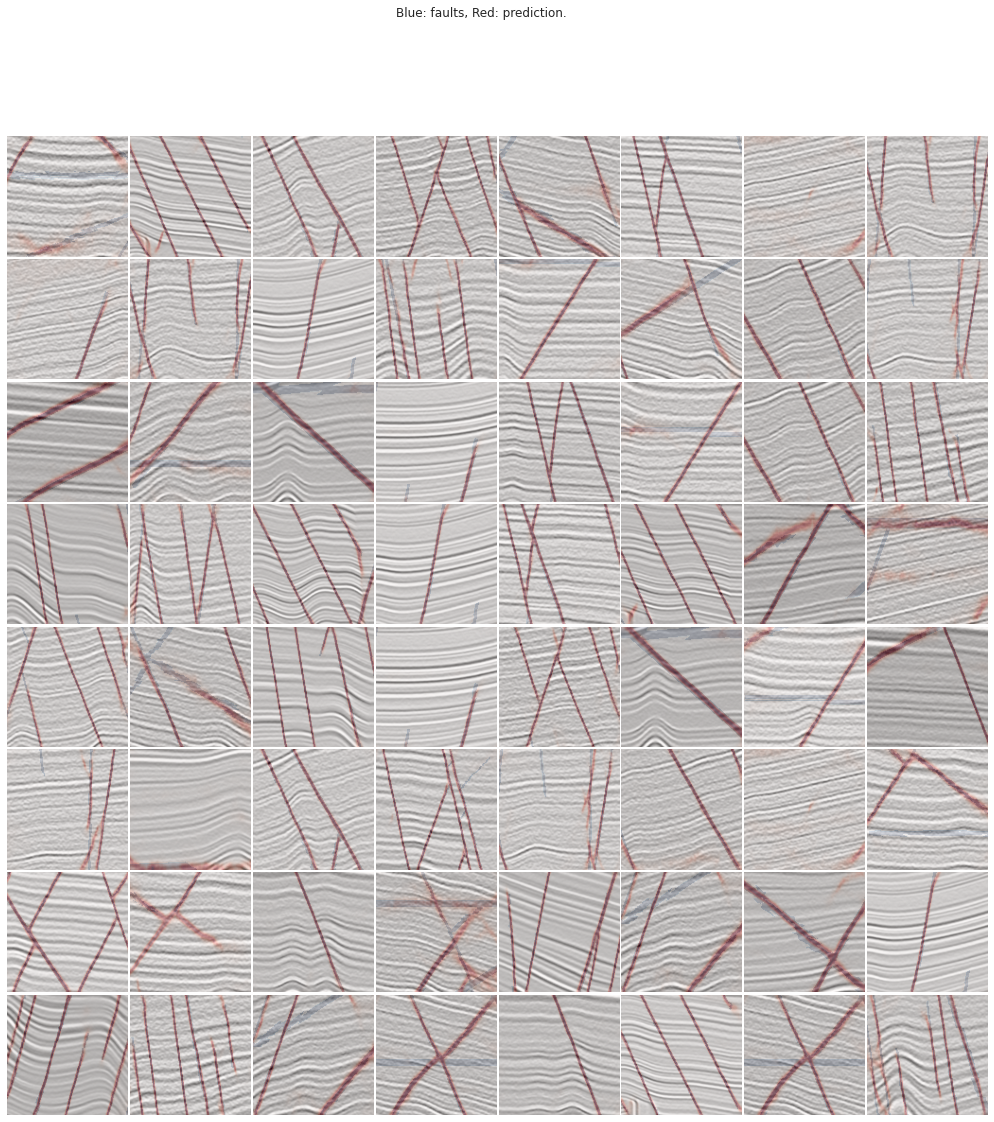

In [35]:
fig = plotImageTranspValid(validation_images, validation_masks, preds_valid, k = 8, alpha1 = 0.2, alpha2 = 0.3)

### Select a better threshold

In [36]:
import numpy as np

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [37]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(validation_masks, np.int32(preds_valid > threshold)) for threshold in thresholds])

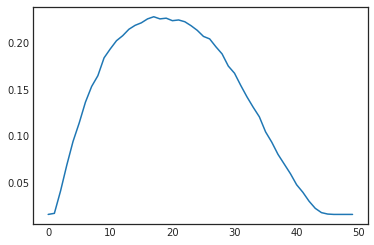

In [39]:
plt.plot(ious)
plt.show()

In [40]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

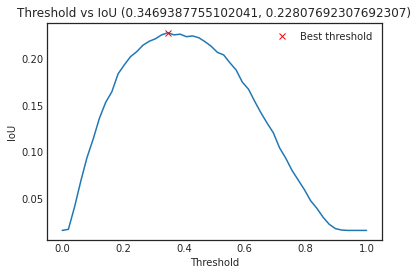

In [41]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

New predictions using best threshold:

In [42]:
predictions = np.int32(preds_valid > threshold_best)

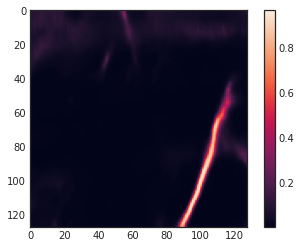

In [44]:
plt.imshow(preds_valid[0])
plt.colorbar()
plt.show()

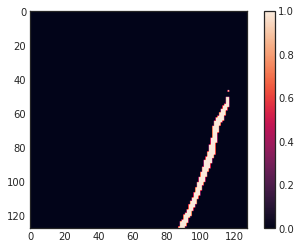

In [45]:
plt.imshow(predictions[0])
plt.colorbar()
plt.show()

Define a function to plot

In [46]:
def plotImageTransp(file1, file2, k, alpha = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].imshow(file2[ind], cmap='Purples', alpha = alpha)
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    return(fig)

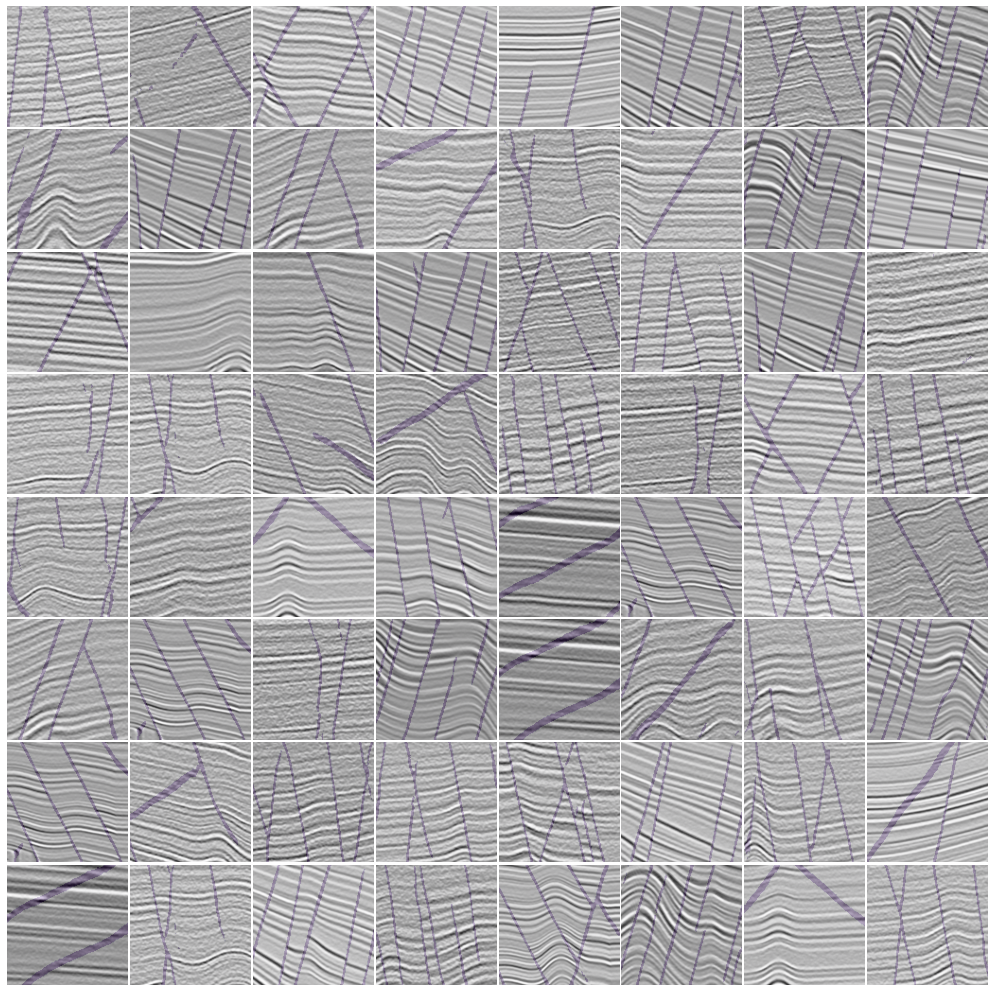

In [47]:
fig = plotImageTransp(validation_images, predictions, k = 8)